In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from torch_fidelity import calculate_metrics

In [2]:

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


In [3]:
# Hyperparameters
image_size = 64
batch_size = 128
nz = 100        # Size of z latent vector (i.e., size of generator input)
num_epochs = 50
lr = 0.00005    # Learning rate for optimizers
n_critic = 5    # Number of critic iterations per generator iteration
weight_clip = 0.01  # Weight clipping parameter

# Create output directories if they don't exist
os.makedirs('output_images_wgan', exist_ok=True)
os.makedirs('generated_images_wgan_epoch', exist_ok=True)
os.makedirs('real_images_wgan', exist_ok=True)

# Transformation pipeline for the input data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [4]:

# Load the CIFAR10 dataset
dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Weights initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # For Convolutional layers
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.zeros_(m.bias.data)
    elif classname.find('Linear') != -1:
        # For Linear layers
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.zeros_(m.bias.data)
    elif classname.find('BatchNorm') != -1:
        # For BatchNorm layers
        nn.init.ones_(m.weight.data)
        nn.init.zeros_(m.bias.data)

Files already downloaded and verified


In [5]:

# Generator model definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a linear layer
            nn.Linear(nz, 4*4*512),
            nn.BatchNorm1d(4*4*512),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 4, 4)),  # Reshape output to (512, 4, 4)
            # Upsampling layers
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()  # Output layer with Tanh activation
        )

    def forward(self, input):
        output = self.main(input)
        return output

# Initialize the generator
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (4): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 3, kernel_size=(5

In [6]:

# Critic (Discriminator) model definition
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            # Input is (3, 64, 64)
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(4*4*512, 1),
            # No activation function for WGAN
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)

# Initialize the critic
netC = Critic().to(device)
netC.apply(weights_init)
print(netC)


Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=8192, out_features=1, bias=True)
  )
)


In [8]:

# Optimizers for generator and critic
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)
optimizerC = optim.RMSprop(netC.parameters(), lr=lr)

# Fixed noise for generating images
fixed_noise = torch.randn(64, nz, device=device)

# Lists to keep track of progress
img_list = []
G_losses = []
C_losses = []
FID_scores = []
FID_epochs = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update Critic network
        ###########################
        real_images = data[0].to(device)
        b_size = real_images.size(0)

        for _ in range(n_critic):
            netC.zero_grad()

            # Train on real images
            output_real = netC(real_images)
            loss_real = -torch.mean(output_real)

            # Generate fake images
            noise = torch.randn(b_size, nz, device=device)
            fake_images = netG(noise).detach()
            output_fake = netC(fake_images)
            loss_fake = torch.mean(output_fake)

            # Total loss for critic
            loss_C = loss_real + loss_fake
            loss_C.backward()
            optimizerC.step()

            # Weight clipping for Lipschitz constraint
            for p in netC.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        ############################
        # (2) Update Generator network
        ###########################
        netG.zero_grad()

        # Generate fake images
        noise = torch.randn(b_size, nz, device=device)
        fake_images = netG(noise)
        output = netC(fake_images)
        loss_G = -torch.mean(output)
        loss_G.backward()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        C_losses.append(loss_C.item())

        # Output training stats
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] \
Loss_C: {loss_C.item():.4f} Loss_G: {loss_G.item():.4f}")

        # Save generated images periodically
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            # Save images
            vutils.save_image(fake, f'output_images_wgan/epoch_{epoch}_iter_{i}.png', normalize=True)

        iters += 1

    #############################################
    # Compute FID Score every 4 epochs
    #############################################
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        netG.eval()  # Set generator to evaluation mode

        # Parameters for image generation
        num_fake_images = 5000  # Number of fake images to generate for FID computation
        fid_batch_size = 64

        # Directories for images
        fake_images_dir = f'generated_images_wgan_epoch/epoch_{epoch+1}'
        os.makedirs(fake_images_dir, exist_ok=True)

        print(f"Generating fake images for FID computation at epoch {epoch+1}...")
        for i in range(0, num_fake_images, fid_batch_size):
            noise = torch.randn(fid_batch_size, nz, device=device)
            with torch.no_grad():
                fake_images = netG(noise).detach().cpu()
            for j in range(fake_images.size(0)):
                idx = i + j
                if idx >= num_fake_images:
                    break
                vutils.save_image(fake_images[j], f'{fake_images_dir}/fake_{idx}.png', normalize=True)

        # Collect real images
        real_images_dir = 'real_images_wgan'
        if epoch == 0:
            os.makedirs(real_images_dir, exist_ok=True)
            print("Collecting real images for FID computation...")
            counter = 0
            for data in dataloader:
                images, _ = data
                for j in range(images.size(0)):
                    if counter >= num_fake_images:
                        break
                    vutils.save_image(images[j], f'{real_images_dir}/real_{counter}.png', normalize=True)
                    counter += 1
                if counter >= num_fake_images:
                    break

        # Compute FID score
        print(f"Computing FID score at epoch {epoch+1}...")
        metrics = calculate_metrics(
            input1=real_images_dir,
            input2=fake_images_dir,
            cuda=torch.cuda.is_available(),
            isc=False,  # Inception Score
            fid=True,   # Fréchet Inception Distance
            kid=False,  # Kernel Inception Distance
            verbose=False
        )

        fid_score = metrics['frechet_inception_distance']
        FID_scores.append(fid_score)
        FID_epochs.append(epoch + 1)

        print(f"Epoch [{epoch+1}/{num_epochs}] FID Score: {fid_score:.5f}")

        # Clean up fake images directory to save space
        import shutil
        shutil.rmtree(fake_images_dir)

        netG.train()  # Set generator back to training mode

# Save final generated images
os.makedirs('final_images_wgan', exist_ok=True)
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
vutils.save_image(fake, 'final_images_wgan/final_generated_images.png', normalize=True)


Starting Training Loop...
Epoch [1/50] Batch [0/391] Loss_C: -0.4880 Loss_G: 0.5967
Epoch [1/50] Batch [100/391] Loss_C: -1.4680 Loss_G: 0.7229
Epoch [1/50] Batch [200/391] Loss_C: -1.5388 Loss_G: 0.7611
Epoch [1/50] Batch [300/391] Loss_C: -1.2668 Loss_G: 0.6127
Epoch [2/50] Batch [0/391] Loss_C: -0.7974 Loss_G: 0.0740
Epoch [2/50] Batch [100/391] Loss_C: -1.4884 Loss_G: 0.7366
Epoch [2/50] Batch [200/391] Loss_C: -1.4604 Loss_G: 0.7126
Epoch [2/50] Batch [300/391] Loss_C: -1.4594 Loss_G: 0.7143
Epoch [3/50] Batch [0/391] Loss_C: -1.4634 Loss_G: 0.7287
Epoch [3/50] Batch [100/391] Loss_C: -0.7727 Loss_G: 0.6736
Epoch [3/50] Batch [200/391] Loss_C: -1.4703 Loss_G: 0.7287
Epoch [3/50] Batch [300/391] Loss_C: -1.4126 Loss_G: 0.6763
Epoch [4/50] Batch [0/391] Loss_C: -1.4698 Loss_G: 0.7278
Epoch [4/50] Batch [100/391] Loss_C: -1.4686 Loss_G: 0.7262
Epoch [4/50] Batch [200/391] Loss_C: -1.5249 Loss_G: 0.7481
Epoch [4/50] Batch [300/391] Loss_C: -1.4807 Loss_G: 0.7202
Epoch [5/50] Batch [0/

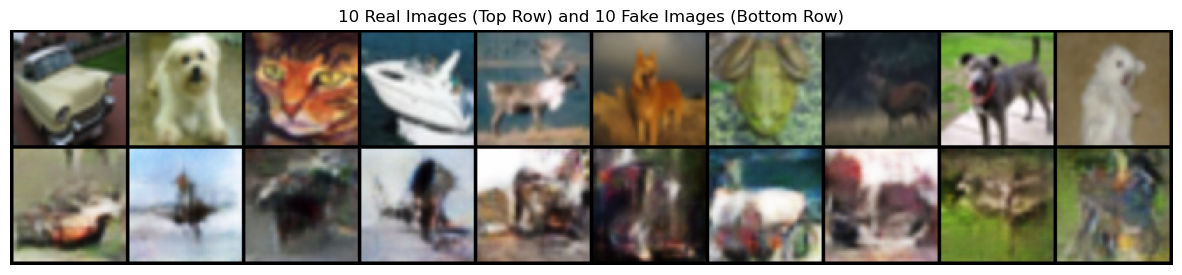

In [9]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch

# Select 10 real images from the dataloader
real_images = next(iter(dataloader))[0][:10].to(device)

# Generate 10 fake images using the generator
noise = torch.randn(10, nz, device=device)
fake_images = netG(noise).detach()

# Combine real and fake images for comparison
comparison_images = torch.cat([real_images.cpu(), fake_images.cpu()])

# Plot real images (top row) and fake images (bottom row)
plt.figure(figsize=(15, 6))
plt.axis("off")
plt.title("10 Real Images (Top Row) and 10 Fake Images (Bottom Row)")
plt.imshow(vutils.make_grid(comparison_images, nrow=10, padding=2, normalize=True).permute(1, 2, 0))
plt.show()


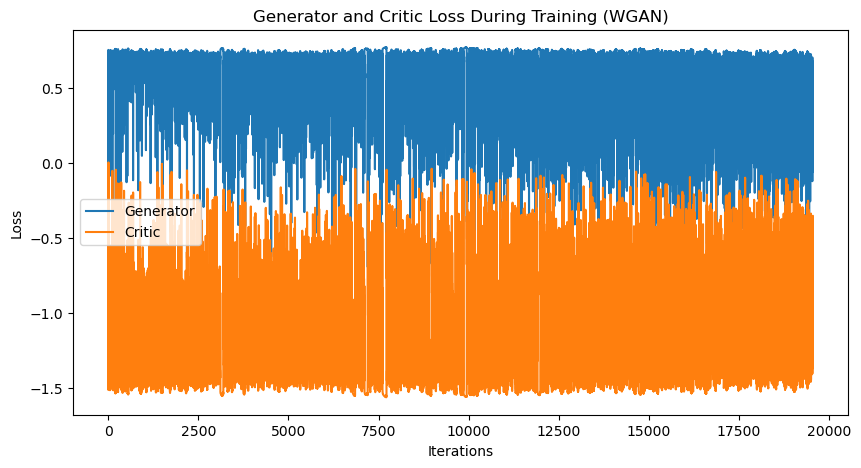

In [10]:

# Plot the training losses
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training (WGAN)")
plt.plot(G_losses,label="Generator")
plt.plot(C_losses,label="Critic")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


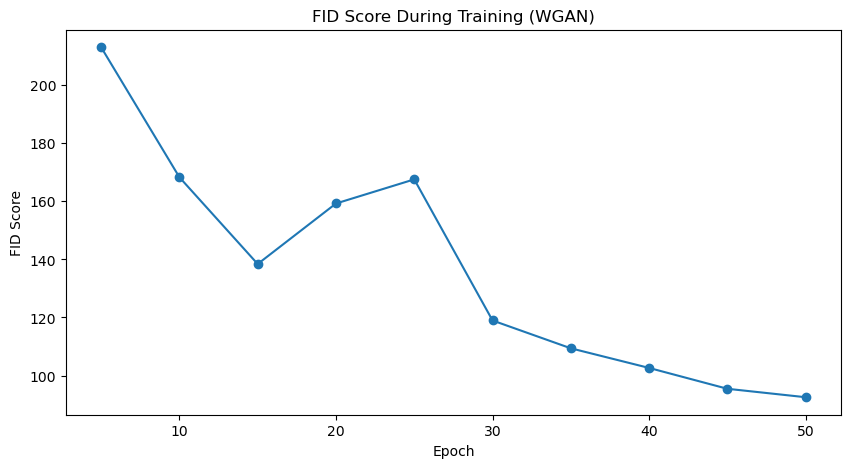

In [11]:

# Plot FID scores over epochs
plt.figure(figsize=(10,5))
plt.title("FID Score During Training (WGAN)")
plt.plot(FID_epochs, FID_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.show()